<a href="https://colab.research.google.com/github/Camouflage10/disease-spread-model/blob/forest-boosting/disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
#comment out pips when uploading
#!pip install ruamel.yaml

In [67]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sn
#from ruamel.yaml import YAML
import json
import xgboost as xgb

In [68]:
def load_params():
    "Updates FULL_PARAMS with the values in params.yaml and returns all as a dictionary"
    yaml = YAML(typ="safe")
    with open("params.yaml") as f:
        params = yaml.load(f)
    return params

In [69]:
from matplotlib import text
x = pd.read_csv ('dengue_features_train.csv')
y = pd.read_csv ('dengue_labels_train.csv')
test = pd.read_csv ('dengue_features_test.csv')

In [70]:
x

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4/30/1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,5/7/1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,5/14/1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,5/21/1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,5/28/1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,iq,2010,21,5/28/2010,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1195,iq,2010,22,6/4/2010,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1196,iq,2010,23,6/11/2010,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1197,iq,2010,24,6/18/2010,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [71]:
y

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


In [72]:
test=test.drop(columns=['city','year','week_start_date'])
y=y.drop(columns=['city','year'])
x=x.drop(columns=['city','year','week_start_date'])

In [73]:
#data analysis
minCorr=.2
x['total_cases']=y['total_cases']
corrMatrix = x.corr()
lastCol=corrMatrix.iloc[:,-1]
print(lastCol)
features=list(lastCol.loc[abs(lastCol) > minCorr].index)
print(features)
x=x[features]
corrMatrix = x.corr()
#sn.heatmap(corrMatrix, annot=True)
#plt.show()

weekofyear                              -0.105808
ndvi_ne                                 -0.100154
ndvi_nw                                 -0.078538
ndvi_se                                 -0.107336
ndvi_sw                                 -0.112200
precipitation_amt_mm                    -0.097127
reanalysis_air_temp_k                    0.018988
reanalysis_avg_temp_k                   -0.084669
reanalysis_dew_point_temp_k             -0.107776
reanalysis_max_air_temp_k               -0.232370
reanalysis_min_air_temp_k                0.157917
reanalysis_precip_amt_kg_per_m2         -0.055013
reanalysis_relative_humidity_percent    -0.157166
reanalysis_sat_precip_amt_mm            -0.097127
reanalysis_specific_humidity_g_per_kg   -0.121422
reanalysis_tdtr_k                       -0.223996
station_avg_temp_c                      -0.075055
station_diur_temp_rng_c                 -0.183734
station_max_temp_c                      -0.139977
station_min_temp_c                       0.074050


In [74]:
from sklearn.model_selection import train_test_split

#remove NaN
x['total_cases']=y['total_cases']
x=x.dropna()
test=test.dropna()
y=x['total_cases']
x=x.drop(columns=['total_cases'])

#preprocessing-train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state = 123)


In [75]:
#MAY NOT NEED

#compressing values
#selecting sj values (2000-2008)
#sj = pd.read_csv ('dengue_labels_train.csv')
#sj = sj[(sj["city"] == 'sj')]
#sj = sj[(sj["year"] > 1999) & (sj["year"] < 2009)]

#selecting iq values (2000-2008)
#iq = pd.read_csv ('dengue_labels_train.csv')
#iq = iq[(iq["city"] == 'iq')]
#iq = iq[(iq["year"] > 1999) & (iq["year"] < 2009)]


In [76]:
#XGBoost example trying to make it work but it most likely won't
#THERE ARE A LOT OF WARNINGS WITH CROSS VAL AND K FOLD
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

#model
xg_reg = xgb.XGBRegressor(objective = 'reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

#fitting the model
xg_reg.fit(X_train, y_train)

#scoring the model
score = xg_reg.score(X_train, y_train)
print("Training Score: ", score)

#cross-val score
scores = cross_val_score(xg_reg, X_train, y_train, cv=10)
print("Mean cross-val score: %.2f" % scores.mean())

#K-Fold cross-val
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xg_reg, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

#MSE and RMSE
preds = xg_reg.predict(X_test)
preds = [round(value) for value in preds]
mse = mean_squared_error(y_test, preds)
print("MSE: %.2f" % mse)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

#accuracy score
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[19:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training Score:  0.10527332742375561
[19:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:li

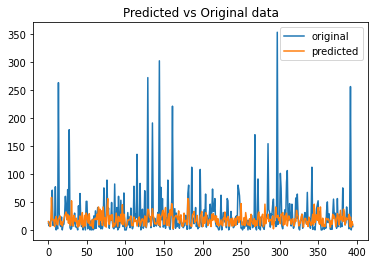

In [77]:
#visualization to see if it looks like it matches
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, preds, label="predicted")
plt.title("Predicted vs Original data")
plt.legend()
plt.show()

In [78]:
#tuning
#tuners that work but it's too much for the RAM
#'booster':['gbtree','gblinear','dart']
#'max_depth':[3,4,5,6,7,8,9,10],'max_delta_step':[0,1],'subsample':[0.5,0.6,0.7,0.8,0.9,1],'colsample_bytree':[0.2,0.4,0.6,0.8,1],
#              'colsample_bylevel':[0.2,0.4,0.6,0.8,1],
#'objective':['reg:linear','reg:squarederror','reg:squaredlogerror','reg:logistic','multi:softmax','multi:softprob'] automatically linear

parameters = {'colsample_bynode':[0.2,0.4,0.6,0.8,1],'lamda':[1,2,3,4,5],'n_estimators':[2,5,10,15,20,30,40,50],'learning_rate':[0.1,0.3,0.5,0.7,0.9,1],
              'booster':['gbtree','gblinear','dart']}
xg_reg.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.3,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 10,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1,
 'alpha': 10}

In [83]:
from sklearn.model_selection import GridSearchCV

xgb_tuned_model = xgb.XGBRegressor()
tuned = GridSearchCV(xgb_tuned_model, parameters, n_jobs = -1)
tuned.fit(X_train, y_train)

print('Best parameters: ', tuned.best_params_,"\n")

[19:13:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters:  {'booster': 'gblinear', 'colsample_bynode': 0.2, 'lamda': 1, 'learning_rate': 1, 'n_estimators': 5} 



In [86]:
#testing
#cross-val score
#new_scores = cross_val_score(tuned, X_train, y_train, cv=10)
#print("Mean cross-val score: %.2f" % new_scores.mean())

#RMSE and MSE
best = tuned.best_params_
new_tuned = xgb.XGBRegressor(booster=best['booster'],colsample_bynode=best['colsample_bynode'],lamda=best['lamda'],learning_rate=best['learning_rate'],n_estimators=best['n_estimators'])

new_tuned.fit(X_train, y_train)

preds = new_tuned.predict(X_test)
preds = [round(value) for value in preds]
mse = mean_squared_error(y_test, preds)
print("MSE: %.2f" % mse)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[19:20:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 1669.93
RMSE: 40.864830


In [81]:
#create metrics.json (optional metrics.txt also)
value = {
        "loss": 0,
        "rmse": 0,
    }
with open('metrics.json', 'w') as outfile:
  outfile.write(json.dumps(value))

In [82]:
#create a graph called stats.png
plt.tight_layout()
fig1 = plt.gcf()
fig1.savefig('stats.png', dpi=100)

<Figure size 432x288 with 0 Axes>